## 初始化

In [6]:
import torch
from model import Model,device
from eeg_dataset import EEG_Dataset

'''从分类结果获得显著图'''
dataset = EEG_Dataset(path='C:/Users/14152/Desktop/eegbin/dataset')
m = Model(8,5).to(device)
state_dict = torch.load('C:/Users/14152/Desktop/eegbin/log/best_model_dispose_0.pth')
m.load_state_dict(state_dict)
m.eval() 

Loaded files: ['co_1_1.npz', 'co_1_2.npz', 'co_3_1.npz', 'co_3_2.npz', 'vs_1_1.npz', 'vs_2_1.npz', 'vs_3_1.npz']
Total entries: 8362
co count: 4103
vs count: 4259


Model(
  (gcn1): GCNConv(5, 40)
  (gcn2): GCNConv(40, 40)
  (gcn3): GCNConv(40, 40)
  (gcn4): GCNConv(40, 1)
  (fc_g): Linear(in_features=16, out_features=16, bias=True)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_c): Linear(in_features=4096, out_features=16, bias=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)

## 样本前向计算

合作：[0.6, 0.4]
对抗：[0.4, 0.6]

In [7]:
(x1,x2),y = dataset[1000]
x1 = x1.unsqueeze(0)
x2 = x2.unsqueeze(0)
x1.requires_grad_(),x2.requires_grad_()

print(x1.shape,x2.shape)
output = m(x1,x2)

prediction = output.argmax().item()
truth = y.argmax().item()


print(f"预测：{output},{prediction}\n实际：{y},{truth}\n{prediction==truth}")

torch.Size([1, 16, 5]) torch.Size([1, 16, 16])
预测：tensor([[4.3712e-01, 4.9988e-11]], device='cuda:0', grad_fn=<SigmoidBackward0>),0
实际：tensor([0.6000, 0.4000], device='cuda:0'),0
True


## 反向计算梯度

注意，下面的cell只能运行一遍，再次运行会报错，需要重新运行上面的cell
因为torch的tensor只能.backward()一次

In [8]:
import numpy as np
m.zero_grad()
output[0, prediction].backward() # 0是batch的维度
saliency_x1 = x1.grad.data.abs().squeeze(0).cpu().detach().numpy()
saliency_x2 = x2.grad.data.abs().squeeze(0).cpu().detach().numpy()

print(np.mean(saliency_x1),np.mean(saliency_x2))
print(np.sum(saliency_x1),np.sum(saliency_x2))

2.9100314e-05 0.0044869673
0.0023280252 1.1486636


## 可视化显著性

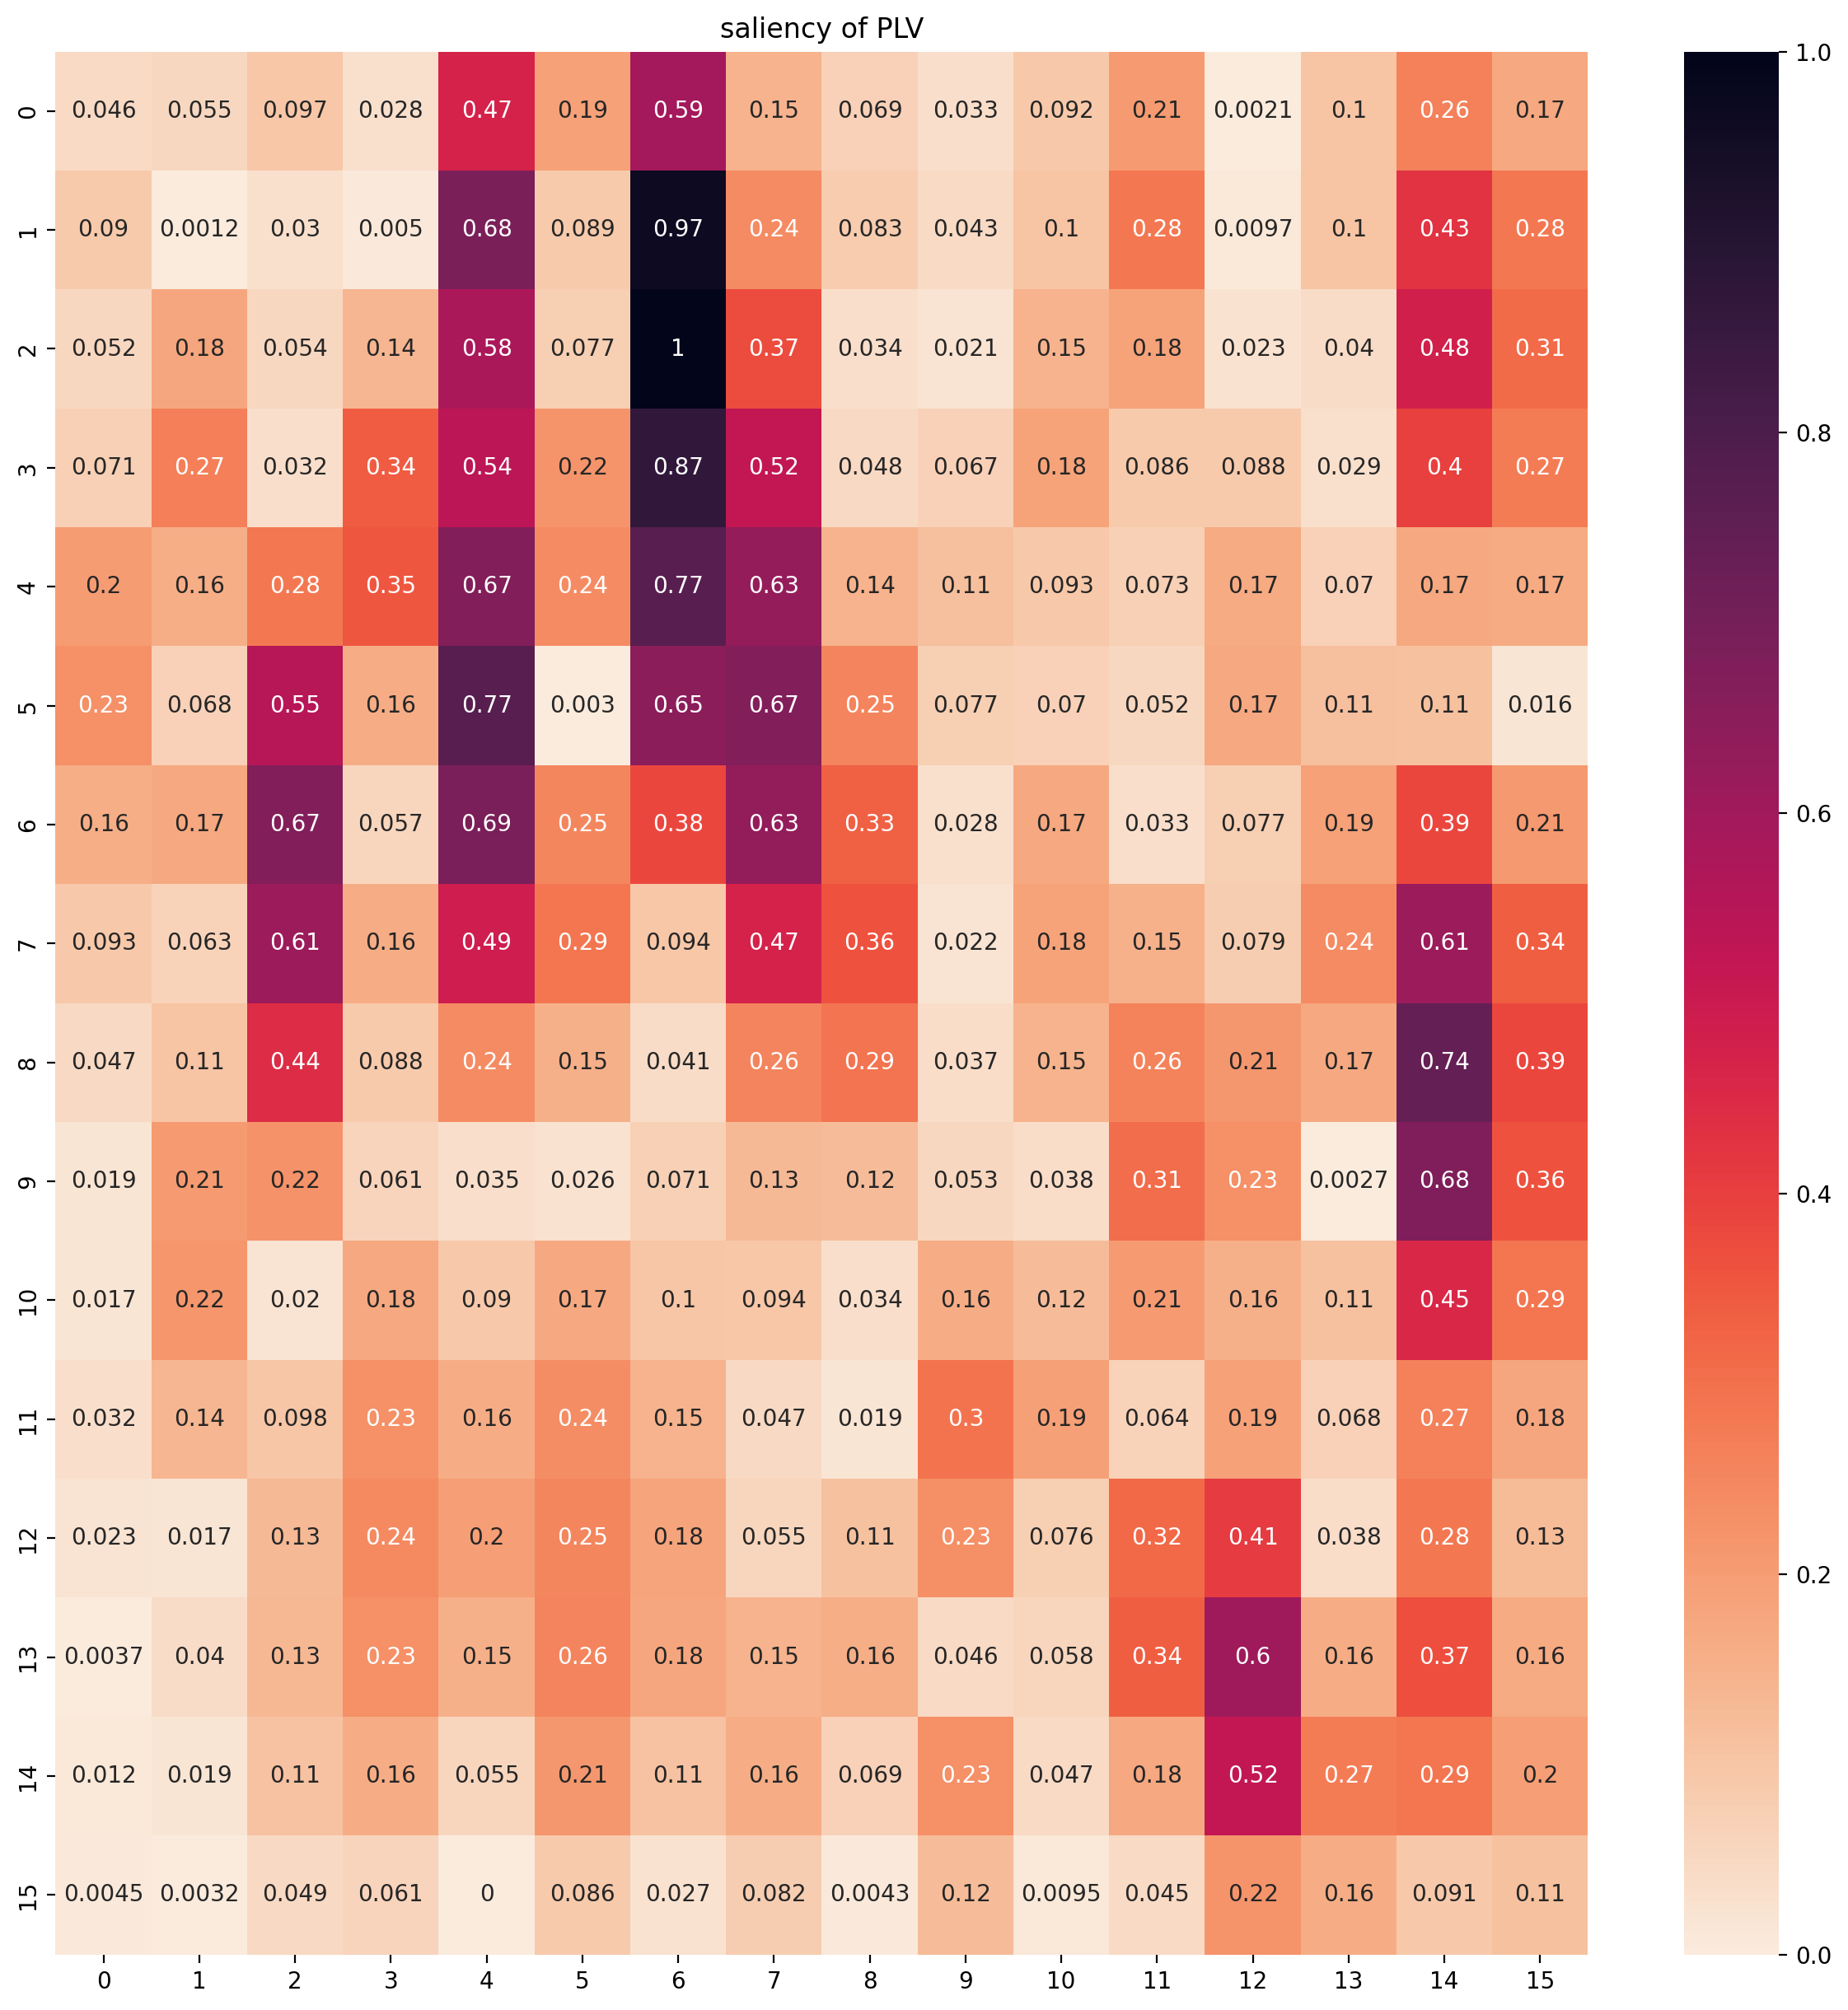

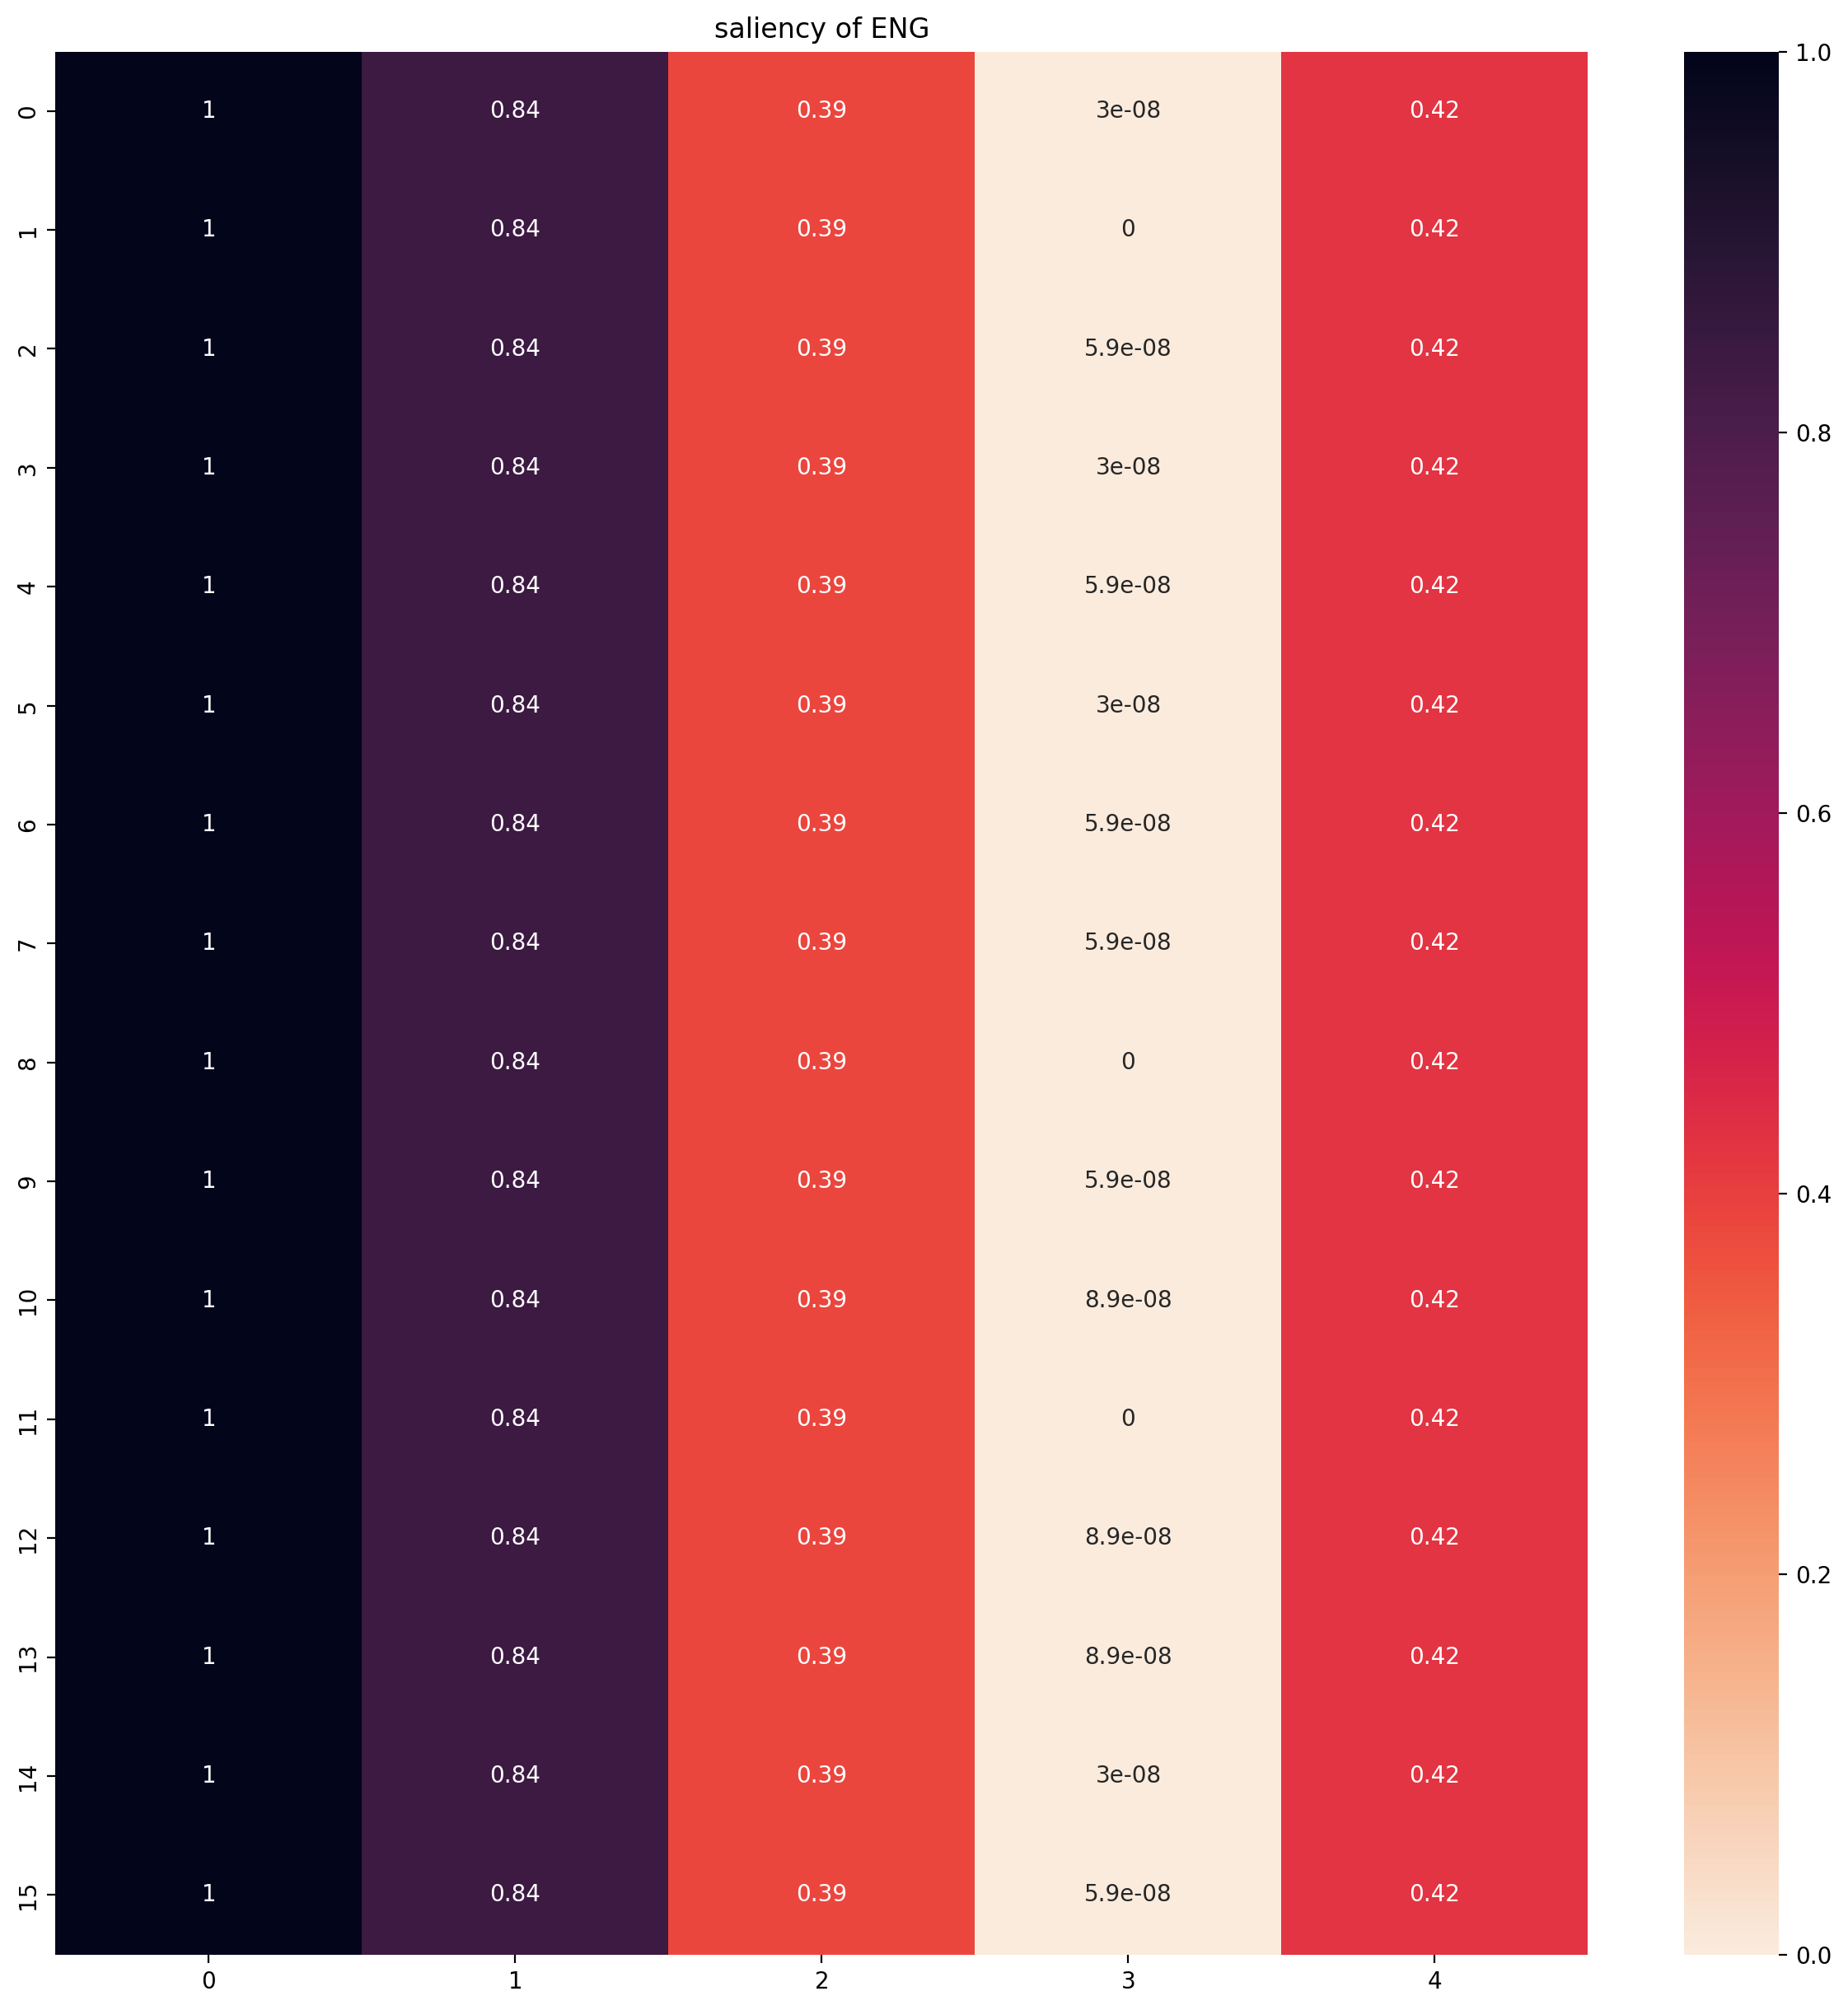

In [9]:
from plot_relation_map import plot_weighted_heatmap
import matplotlib.pyplot as plt


# 归一化一下，好看一些
def normalize_matrix(matrix):
    matrix = np.array(matrix)
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix

saliency_x2 = normalize_matrix(saliency_x2)


print('saliency of PLV')


saliency_x1 = normalize_matrix(saliency_x1)

plt.figure(dpi=200,figsize=(15,15))
sns.heatmap(saliency_x1, annot=True, cmap='rocket_r')
plt.title('saliency of ENG')
plt.show()

## 使用mne绘制能量图与连接图

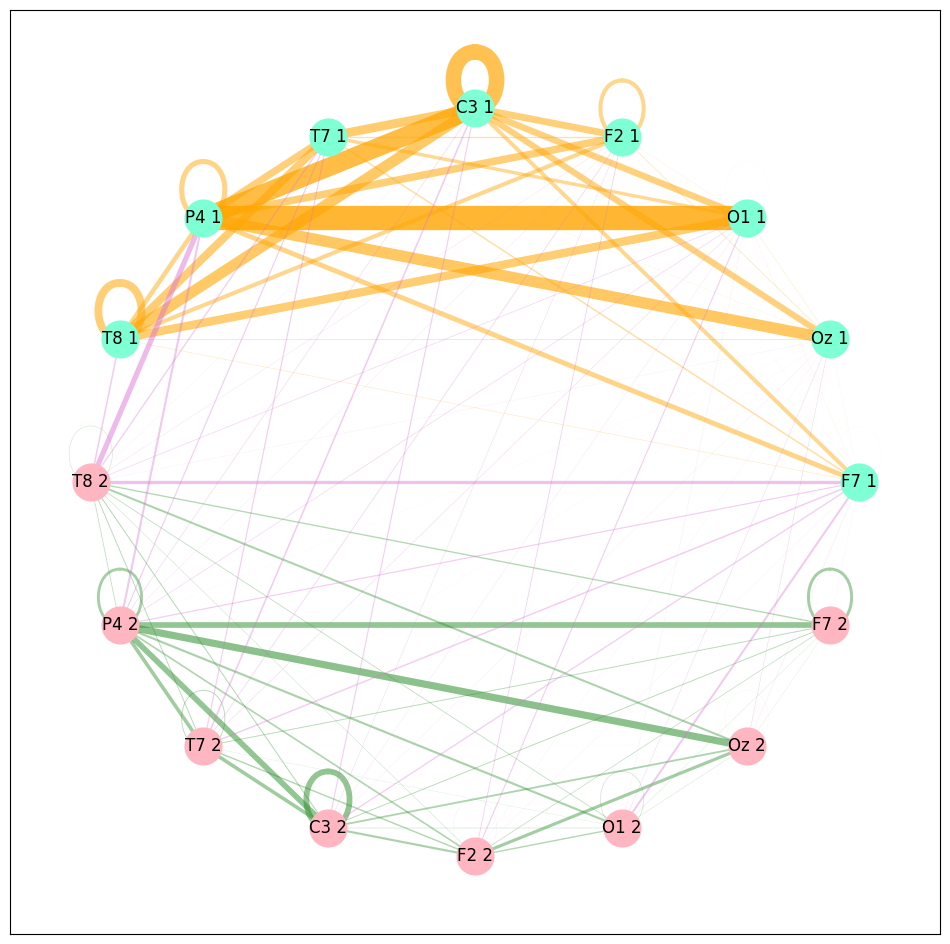

In [10]:
from utils.plot_relation_map import plot_relation_map
node_names = ['F7', 'Oz', 'O1', 'F2', 'C3', 'T7', 'P4', 'T8']
    (saliency_x2,node_names)